In [1]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import tensorflow as tf

In [3]:
# Sets all random seeds for the program (Python, NumPy, and TensorFlow).
random_seed = 2
# tf.keras.utils.set_random_seed(random_seed)

In [4]:
import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from plot_losses import PlotLosses

## Keras modules

In [37]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Flatten

## Cargo datos

In [6]:
# Descomprimir data fashion-mnist-itba-lab-ml-2018b.zip y luego entrar a la carpeta 
# y descomprimir los zips de adentro
folder = './fashion-mnist-itba-lab-ml-2018b/'
!ls {folder}

test_images.npy      train_images.npy     train_labels.csv
test_images.npy.zip  train_images.npy.zip


In [7]:
x = np.load(folder + 'train_images.npy')
y = np.loadtxt(folder + 'train_labels.csv', delimiter=',', skiprows=1)
x_test = np.load(folder + 'test_images.npy')

In [8]:
y

array([9., 0., 0., ..., 3., 0., 5.])

## Lo llevo a formato de imágenes de 28 x 28 x 1

In [9]:
x[0].reshape(-1)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   1,   0,   0,  13,  73,   0,   0,   1,
         4,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   3,   0,  36, 136, 127,  62,
        54,   0,   0,   0,   1,   3,   4,   0,   0,   3,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0, 102, 204,
       176, 134, 144, 123,  23,   0,   0,   0,   0,  12,  10,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [10]:
from matplotlib import pyplot as plt

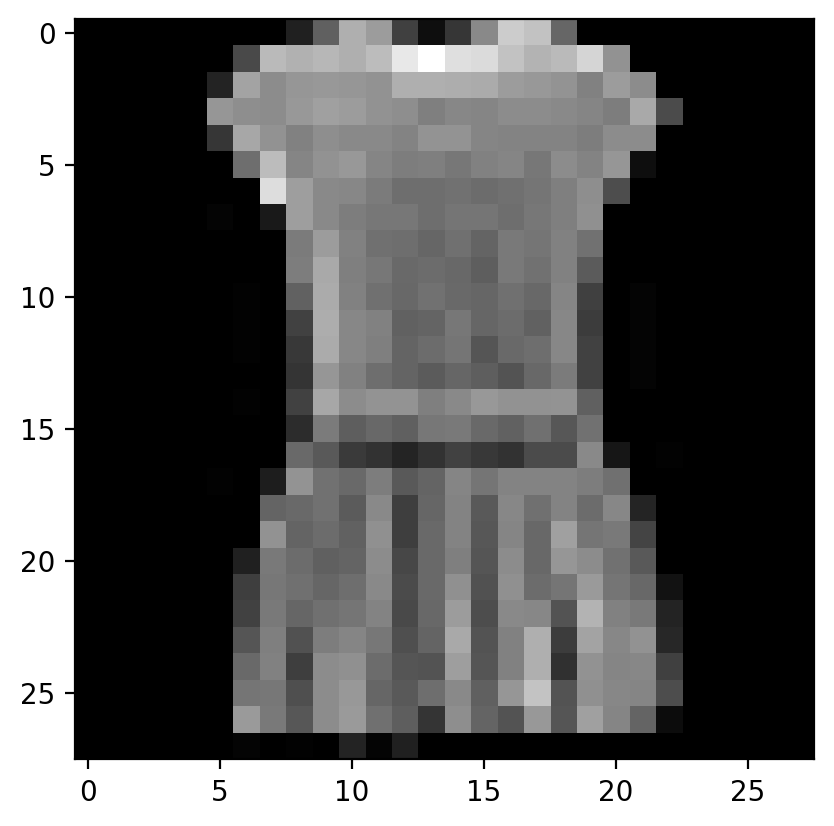

In [11]:
plt.imshow(x[3], cmap='gray')
plt.show()

In [12]:
x = np.expand_dims(x, axis=3)
x.shape

(60000, 28, 28, 1)

In [13]:
x_test = np.expand_dims(x_test, axis=3)
x_test.shape

(10000, 28, 28, 1)

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

## Paso a float

In [15]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

In [16]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

In [17]:
y_train_categorical.shape

(54000, 10)

## Red neuronal: CNN LeNet-5

In [30]:
activation='relu'
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(5, 5), activation=activation, input_shape=(28,28,1), padding='same'))

model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(5, 5), activation=activation))

model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=120, activation=activation))

model.add(Dense(units=84, activation=activation))

model.add(Dense(units=10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

In [38]:
# Callbacks
## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=20, x_val=x_valid, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='checkpoint.mnist-cnn.hdf5', verbose=1, save_best_only=True)
es_cb = EarlyStopping(monitor='val_loss', patience=3, min_delta=0)

In [32]:
x_train.shape

(54000, 28, 28, 1)

In [33]:
y_train_categorical.shape

(54000, 10)

In [34]:
54_000//128

421

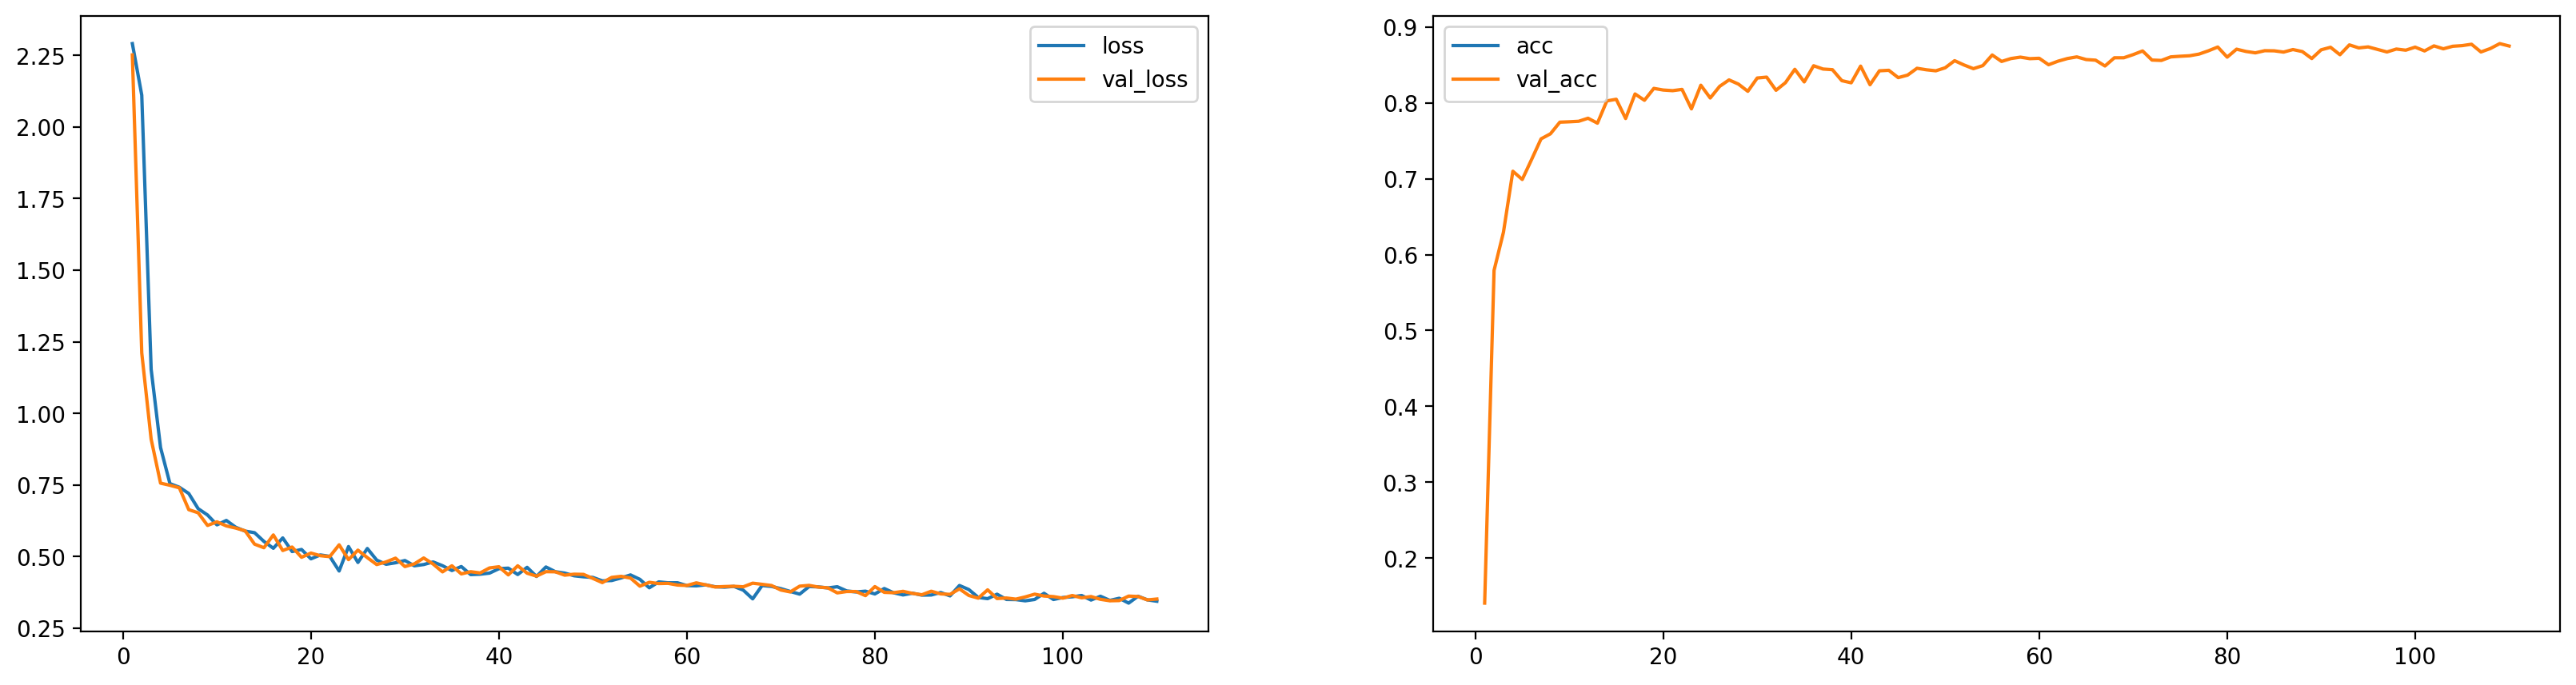


Epoch 00005: val_loss improved from 0.37667 to 0.35956, saving model to checkpoint.mnist-cnn.hdf5


In [35]:
batch_size = 128
epocs = 50

model.fit(
    x_train, 
    y_train_categorical,
    epochs=epocs, 
    batch_size=batch_size, 
    verbose=1, 
    validation_data = (x_valid, y_val_categorical),
    callbacks=[plot_losses, checkpointer, es_cb],
)

In [24]:
model.load_weights('checkpoint.mnist-cnn.hdf5')

In [36]:
loss, acc = model.evaluate(x_valid, y_val_categorical)
# accuracy: 0.8823 tanh
# accuracy: 0.8707 relu

188/188 [==============================] - 1s 3ms/step - loss: 0.3596 - accuracy: 0.8707


In [26]:
print(acc)
# 0.8234999775886536

0.8823333382606506


In [27]:
test_prediction = model.predict(x_test)

In [29]:
test_labels = np.argmax(test_prediction, axis = 1)

In [55]:
model.get_weights()[6].shape

(120, 84)

In [60]:
for l in model.layers:
    print(l.name)
    print(l.get_weights()[0].shape)

conv2d_2
(5, 5, 1, 6)
average_pooling2d_2


IndexError: list index out of range

In [28]:
import pandas as pd
df = pd.DataFrame(data={"Category": test_labels}).astype(int)
df.to_csv("./submission.csv", sep=',',index=True,  index_label='Id')